In [30]:
%pip install --upgrade pip
%pip install torch torchvision
%pip install opencv-python pycocotools tqdm matplotlib


In [31]:
%pip install ultralytics

In [32]:
import torch
import os

def get_device():
    # If you want to allow CPU fallback for ops not implemented on MPS:
    os.environ.setdefault("PYTORCH_ENABLE_MPS_FALLBACK", "1")

    if torch.backends.mps.is_available():
        print("Using Apple MPS")
        return torch.device("mps")
    elif torch.cuda.is_available():
        print(f"Using CUDA GPU: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    else:
        print("Using CPU")
        return torch.device("cpu")

device = get_device()


Using CUDA GPU: NVIDIA L4


In [33]:
print(torch.__version__)
print(torch.version.cuda)

2.9.0+cu126
12.6


In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
# run once every restart
!mkdir -p /content/data
!cp "/content/drive/MyDrive/DL4CVProject/subset_500.zip" /content/data/
%cd /content/data
!unzip -q subset_500.zip
!ls

/content/data
replace subset_500/images/106709.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace subset_500/images/042639.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: df2_yolo_subset  runs  subset_500  subset_500.zip  yolo11n.pt  yolov8s-seg.pt


### 1 One-stage segmentation & detection

Output (YOLO):

boxes = where each object is

masks = which pixels belong to each object

classes = what the object is (COCO label)

In [36]:
# import os

# IMG_DIR = "/content/data/subset_500/images"
# COCO_JSON = "/content/data/subset_500/annotations.json"

# print("Number of images:", len(os.listdir(IMG_DIR)))
# print("First few:", os.listdir(IMG_DIR)[:5])

### Convert COCO subset -> YOLO segmentation format

In [37]:
# Define paths and DeepFashion2 class names
import os, json, random, shutil
from pathlib import Path

import numpy as np
from tqdm import tqdm

COCO_JSON = "/content/data/subset_500/annotations.json"
IMG_DIR = "/content/data/subset_500/images"
OUT_ROOT = "/content/data/df2_yolo_subset"

os.makedirs(OUT_ROOT, exist_ok=True)

# DeepFashion2 categories (id 1..13) -> names
DF2_CATEGORIES = {
    1: "short_sleeve_top",
    2: "long_sleeve_top",
    3: "short_sleeve_outwear",
    4: "long_sleeve_outwear",
    5: "vest",
    6: "sling",
    7: "shorts",
    8: "trousers",
    9: "skirt",
    10: "short_sleeve_dress",
    11: "long_sleeve_dress",
    12: "vest_dress",
    13: "sling_dress",
}

cat_id_to_idx = {cid: cid - 1 for cid in DF2_CATEGORIES.keys()}  # YOLO class indices [0..12]

print("Using COCO JSON:", COCO_JSON)
print("Using images from:", IMG_DIR)
print("Output root:", OUT_ROOT)


Using COCO JSON: /content/data/subset_500/annotations.json
Using images from: /content/data/subset_500/images
Output root: /content/data/df2_yolo_subset


In [38]:
# Load COCO and build image/annotation index
from collections import defaultdict

with open(COCO_JSON, "r") as f:
    coco = json.load(f)

images = coco["images"]
annotations = coco["annotations"]
categories = coco["categories"]

print("Total images in subset:", len(images))
print("Total annotations:", len(annotations))

# Map image_id -> image info
imgid_to_info = {img["id"]: img for img in images}

# Group annotations by image_id
imgid_to_anns = defaultdict(list)
for ann in annotations:
    imgid_to_anns[ann["image_id"]].append(ann)


Total images in subset: 500
Total annotations: 844


In [39]:
# train/val split
image_ids = list(imgid_to_info.keys())
random.seed(42)
random.shuffle(image_ids)

split_idx = int(0.8 * len(image_ids))
train_ids = set(image_ids[:split_idx])
val_ids = set(image_ids[split_idx:])

print(f"Train images: {len(train_ids)}, Val images: {len(val_ids)}")


Train images: 400, Val images: 100


In [40]:
# convert COCO polygons to YOLO segmentation line
#  class_id x1 y1 x2 y2 x3 y3 ...  (all in [0,1], relative to width/height)
def coco_ann_to_yolo_seg_line(ann, img_w, img_h):
    """
    ann: a single COCO annotation with 'category_id' and 'segmentation' list.
    returns: string "cls x1 y1 x2 y2 ..." or None if invalid.
    """
    cat_id = ann["category_id"]
    if cat_id not in DF2_CATEGORIES:
        return None

    cls_idx = cat_id_to_idx[cat_id]

    seg = ann.get("segmentation", [])
    if not seg:
        return None

    # segmentation can be [x1,y1,...] or [[x1,y1,...], [...]]
    if isinstance(seg[0], (int, float)):
        poly = seg
    else:
        # take the first polygon for now
        poly = seg[0]

    if len(poly) < 6 or len(poly) % 2 != 0:
        return None

    xs = poly[0::2]
    ys = poly[1::2]

    # normalize
    norm = []
    for x, y in zip(xs, ys):
        nx = float(x) / img_w
        ny = float(y) / img_h
        norm.extend([nx, ny])

    # basic sanity: all in [0,1]
    if not all(0.0 <= v <= 1.0 for v in norm):
        # could be slightly out due to rounding; you can clip if you prefer
        norm = [min(max(v, 0.0), 1.0) for v in norm]

    # build line
    parts = [str(cls_idx)] + [f"{v:.6f}" for v in norm]
    return " ".join(parts)


In [41]:
# Build YOLO train/val folders
def prepare_split(split_name, img_ids_set):
    img_out_dir = Path(OUT_ROOT) / split_name / "images"
    lbl_out_dir = Path(OUT_ROOT) / split_name / "labels"
    img_out_dir.mkdir(parents=True, exist_ok=True)
    lbl_out_dir.mkdir(parents=True, exist_ok=True)

    count_imgs = 0
    count_anns = 0

    for img_id in tqdm(img_ids_set, desc=f"Preparing {split_name}"):
        info = imgid_to_info[img_id]
        file_name = info["file_name"]
        w, h = info["width"], info["height"]

        src_img_path = Path(IMG_DIR) / file_name
        if not src_img_path.is_file():
            # skip missing image
            continue

        # copy image
        dst_img_path = img_out_dir / file_name
        dst_img_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copy2(src_img_path, dst_img_path)
        count_imgs += 1

        # write label file
        anns = imgid_to_anns.get(img_id, [])
        lines = []
        for ann in anns:
            yolo_line = coco_ann_to_yolo_seg_line(ann, w, h)
            if yolo_line is not None:
                lines.append(yolo_line)

        if lines:
            # label file has same stem as image
            lbl_path = lbl_out_dir / (Path(file_name).stem + ".txt")
            with lbl_path.open("w") as f:
                for line in lines:
                    f.write(line + "\n")
            count_anns += len(lines)
        # if no valid anns, we leave label file missing (YOLO treats as no objects)

    print(f"[{split_name}] images copied: {count_imgs}, label lines written: {count_anns}")


prepare_split("train", train_ids)
prepare_split("val", val_ids)


Preparing train: 100%|██████████| 400/400 [00:00<00:00, 2592.89it/s]


[train] images copied: 400, label lines written: 670


Preparing val: 100%|██████████| 100/100 [00:00<00:00, 2177.31it/s]

[val] images copied: 100, label lines written: 174


In [42]:
# sanity check on processed yolo label file
!ls /content/data/df2_yolo_subset/train/labels | head
!head /content/data/df2_yolo_subset/train/labels/$(ls /content/data/df2_yolo_subset/train/labels | head -n 1)

000566.txt
000851.txt
000930.txt
001704.txt
001886.txt
002051.txt
002442.txt
002535.txt
003010.txt
005106.txt
1 0.995726 0.326923 0.696581 0.431090 0.427350 0.512821 0.497863 0.379808 0.564103 0.235577 0.442308 0.227564 0.271368 0.294872 0.089744 0.358974 0.074786 0.395833 0.070513 0.439103 0.158120 0.480769 0.196581 0.474359 0.215812 0.443910 0.267094 0.424679 0.318376 0.394231 0.211538 0.520833 0.145299 0.668269 0.096154 0.854167 0.115385 0.923077 0.115385 0.998397 0.448718 0.998397 0.758547 0.948718 0.775641 0.878205 0.760684 0.998397 0.993590 0.995192 0.997863 0.600962 0.995726 0.326923


### Create YOLO data.yaml for DeepFashion2 subset

In [43]:
# Create a YAML file that tells YOLO where the dataset and class names are.
yaml_path = os.path.join(OUT_ROOT, "df2_subset.yaml")
names_list = [DF2_CATEGORIES[i] for i in sorted(DF2_CATEGORIES.keys())]

yaml_content = f"""
path: {OUT_ROOT}
train: train/images
val: val/images

nc: {len(names_list)}
names:
"""

for idx, name in enumerate(names_list):
    yaml_content += f"  {idx}: {name}\n"

with open(yaml_path, "w") as f:
    f.write(yaml_content)

print("Wrote data.yaml to:", yaml_path)
print(yaml_content)


Wrote data.yaml to: /content/data/df2_yolo_subset/df2_subset.yaml

path: /content/data/df2_yolo_subset
train: train/images
val: val/images

nc: 13
names:
  0: short_sleeve_top
  1: long_sleeve_top
  2: short_sleeve_outwear
  3: long_sleeve_outwear
  4: vest
  5: sling
  6: shorts
  7: trousers
  8: skirt
  9: short_sleeve_dress
  10: long_sleeve_dress
  11: vest_dress
  12: sling_dress



### Fine-tune YOLOv8-seg on this subset

In [44]:
from ultralytics import YOLO

DATA_YAML = "/content/data/df2_yolo_subset/df2_subset.yaml"

model = YOLO("yolov8s-seg.pt")  # small segmentation model

model.train(
    data=DATA_YAML,
    task="segment",
    epochs=30,        # can adjust
    imgsz=640,
    batch=8,          # adjust down if you hit GPU OOM
    lr0=1e-3,         # can tune later
)


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data/df2_yolo_subset/df2_subset.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7298f440e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038

### Evaluate + compare baseline vs fine-tuned

In [45]:
results = model.val()
results


Ultralytics 8.3.235 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
YOLOv8s-seg summary (fused): 85 layers, 11,784,631 parameters, 0 gradients, 39.9 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1964.5±423.7 MB/s, size: 72.6 KB)
val: Scanning /content/data/df2_yolo_subset/val/labels.cache... 100 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 100/100 226.0Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 7/7 3.2it/s 2.2s
                   all        100        174      0.486      0.579      0.533      0.427      0.488       0.58      0.528      0.357
      short_sleeve_top         48         50      0.657      0.806      0.789      0.622       0.64      0.783       0.77       0.57
       long_sleeve_top         17         17      0.647      0.471      0.582      0.455      0.651      0.471      0.548      0.339
   long_sleeve_outwear          

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([ 0,  1,  3,  4,  6,  7,  8,  9, 10, 11, 12])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e7298cf94f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)', 'Precision-Recall(M)', 'F1-Confidence(M)', 'Precision-Confidence(M)', 'Recall-Confidence(M)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038

In [46]:
test_img = "/content/data/subset_500/images/055739.jpg"  # change to something real
# baseline
base_model = YOLO("yolov8s-seg.pt")
base_res = base_model(test_img, task="segment")
# finetuned
ft_model = YOLO("runs/segment/train/weights/best.pt")
ft_res = ft_model(test_img, task="segment")


image 1/1 /content/data/subset_500/images/055739.jpg: 576x640 1 person, 2 benchs, 1 handbag, 11.4ms
Speed: 1.6ms preprocess, 11.4ms inference, 2.3ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/data/subset_500/images/055739.jpg: 576x640 1 short_sleeve_top, 1 shorts, 8.5ms
Speed: 1.4ms preprocess, 8.5ms inference, 1.8ms postprocess per image at shape (1, 3, 576, 640)


Baseline (COCO-pretrained):


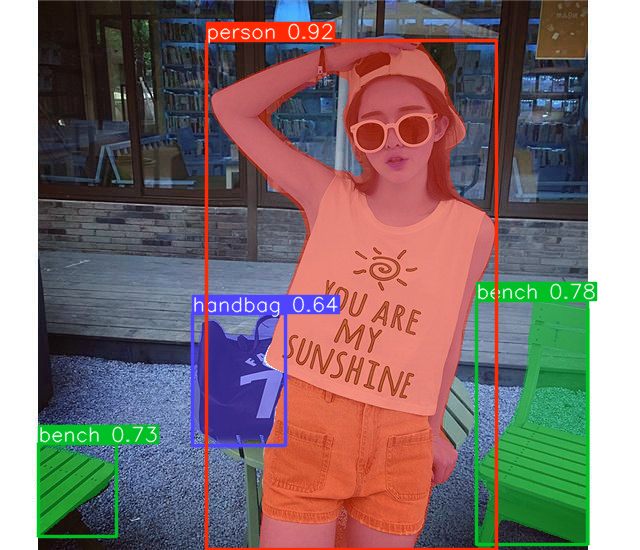

Fine-tuned on DeepFashion2 subset:


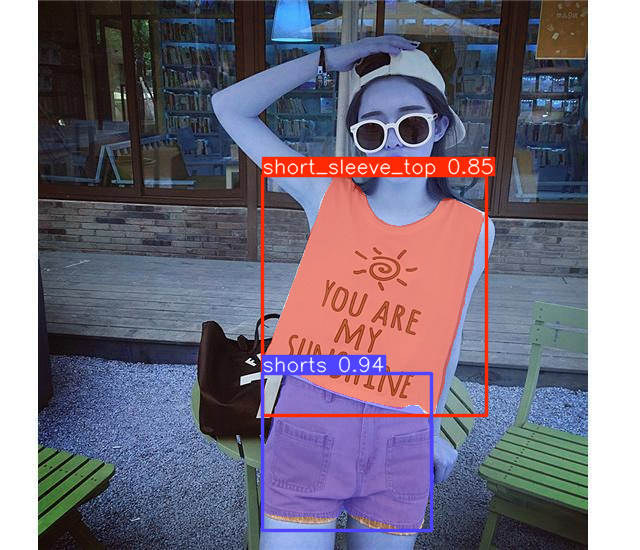

In [47]:
from PIL import Image
from IPython.display import display

base_img = Image.fromarray(base_res[0].plot())
ft_img = Image.fromarray(ft_res[0].plot())

print("Baseline (COCO-pretrained):")
display(base_img)
print("Fine-tuned on DeepFashion2 subset:")
display(ft_img)


### 2 Masked garment crops + metadata
#### We transform YOLO's per-image predictions into a persistent, garment-level dataset (crops + metadata), which we then use for color analysis and future style modeling:

resize masks to image size

crop each box

zero out background (mask < threshold) → masked garment crop

save these crops as PNG files

write a JSONL line per crop with: original image name, crop filename, bbox, class name

In [48]:
import os
from ultralytics import YOLO

IMG_DIR = "/content/data/subset_500/images"
PROJECT_DIR = "/content/drive/MyDrive/DL4CVProject"

# new folder so we keep fine-tuned results separate
CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops_finetuned")
os.makedirs(CROPS_DIR, exist_ok=True)

# path from step 1
FINETUNED_WEIGHTS = "runs/segment/train/weights/best.pt"  # change if needed

model = YOLO(FINETUNED_WEIGHTS)
print("Loaded fine-tuned model. Classes:", model.names)

Loaded fine-tuned model. Classes: {0: 'short_sleeve_top', 1: 'long_sleeve_top', 2: 'short_sleeve_outwear', 3: 'long_sleeve_outwear', 4: 'vest', 5: 'sling', 6: 'shorts', 7: 'trousers', 8: 'skirt', 9: 'short_sleeve_dress', 10: 'long_sleeve_dress', 11: 'vest_dress', 12: 'sling_dress'}


In [55]:
import cv2
import json
import numpy as np
from tqdm import tqdm

N = 20  # or more if you want
META_PATH = os.path.join(PROJECT_DIR, "garment_crops_finetuned_meta.jsonl")

img_list = sorted(os.listdir(IMG_DIR))[:N]
print(f"Processing {len(img_list)} images with fine-tuned model...")

with open(META_PATH, "w") as meta_f:
    for img_name in tqdm(img_list):
        img_path = os.path.join(IMG_DIR, img_name)
        img = cv2.imread(img_path)

        if img is None:
            print("Failed to read:", img_path)
            continue

        h, w = img.shape[:2]

        # run segmentation
        results = model(img, task="segment", verbose=False)
        r = results[0]

        if r.masks is None:
            continue

        boxes = r.boxes.xyxy.cpu().numpy().astype(int)
        classes = r.boxes.cls.cpu().numpy().astype(int)
        masks = r.masks.data.cpu().numpy()
        names = model.names

        for i, (box, cls, mask) in enumerate(zip(boxes, classes, masks)):
            # resize mask to image size
            mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)

            x1, y1, x2, y2 = box
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w, x2), min(h, y2)
            if x2 <= x1 or y2 <= y1:
                continue

            crop = img[y1:y2, x1:x2]
            mask_crop = mask_resized[y1:y2, x1:x2]

            crop_masked = crop.copy()
            crop_masked[mask_crop < 0.5] = 0

            cls_name = names.get(cls, str(cls))
            base = os.path.splitext(img_name)[0]
            out_name = f"{base}_obj{i}_{cls_name}.png"
            out_path = os.path.join(CROPS_DIR, out_name)

            cv2.imwrite(out_path, crop_masked)

            meta = {
                "orig_image": img_name,
                "crop_file": out_name,
                "bbox": [int(x1), int(y1), int(x2), int(y2)],
                "class_id": int(cls),
                "class_name": cls_name,
            }
            meta_f.write(json.dumps(meta) + "\n")

print("Done. Fine-tuned crops saved to:", CROPS_DIR)
print("Metadata saved to:", META_PATH)

Processing 20 images with fine-tuned model...


100%|██████████| 20/20 [00:00<00:00, 27.35it/s]

Done. Fine-tuned crops saved to: /content/drive/MyDrive/DL4CVProject/garment_crops
Metadata saved to: /content/drive/MyDrive/DL4CVProject/garment_crops_finetuned_meta.jsonl


Showing these crops: ['000150_obj0_person.png', '000150_obj0_vest_dress.png', '000150_obj1_cell phone.png', '000566_obj0_long_sleeve_top.png', '000566_obj0_person.png', '000851_obj0_person.png']


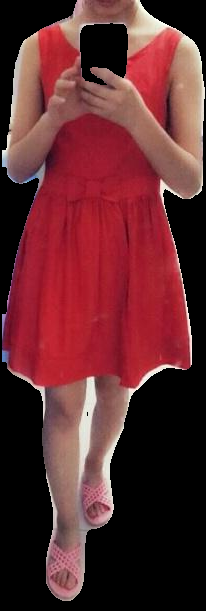

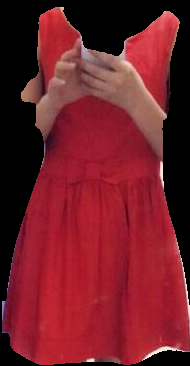

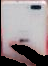

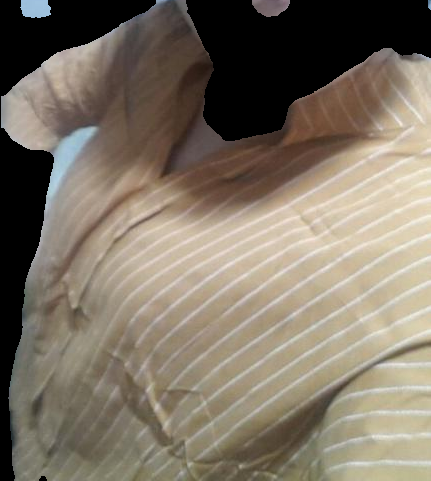

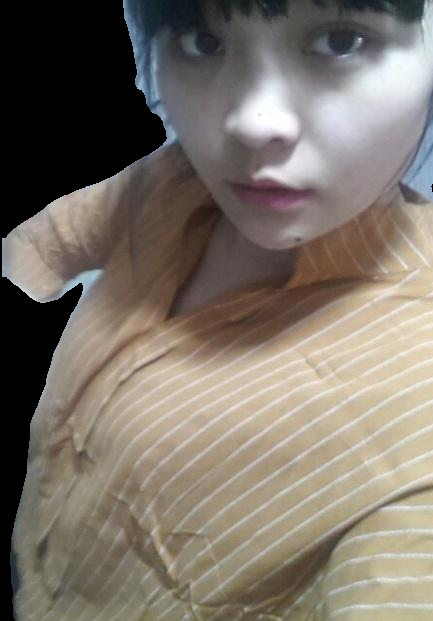

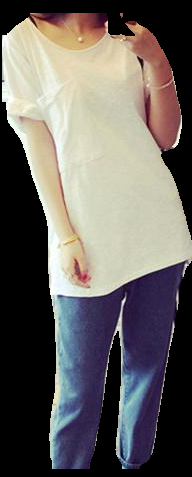

In [56]:
# sanity check: show some crops
from IPython.display import display
from PIL import Image

crop_files = sorted(os.listdir(CROPS_DIR))[:6]
print("Showing these crops:", crop_files)

for cf in crop_files:
    cp = os.path.join(CROPS_DIR, cf)
    display(Image.open(cp))

### 3 Color features per garment

Read the saved crops and metadata

Compute HSV stats and k-means dominant colors

Save a CSV of numeric features

In [57]:
import os
import cv2
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from pathlib import Path

CROPS_DIR = os.path.join(PROJECT_DIR, "garment_crops")
META_PATH = os.path.join(PROJECT_DIR, "garment_crops_meta.jsonl")
FEAT_CSV = os.path.join(PROJECT_DIR, "garment_color_features.csv")

print("Crops dir:", CROPS_DIR)
print("Meta path:", META_PATH)

def compute_color_features(img_bgr, min_pixels=50, k=3):
    """
    img_bgr: HxWx3 BGR image (crop) with background black (0,0,0).
    Returns: dict with simple color stats + k-means dominant colors.
    """
    # mask: non-black pixels
    mask = np.any(img_bgr > 0, axis=-1)
    if mask.sum() < min_pixels:
        return None  # too few garment pixels

    # get garment pixels in HSV
    img_hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    pixels = img_hsv[mask]  # Nx3

    # basic stats
    H = pixels[:, 0].astype(np.float32)  # [0,180] in OpenCV
    S = pixels[:, 1].astype(np.float32)  # [0,255]
    V = pixels[:, 2].astype(np.float32)  # [0,255]

    mean_h = float(np.mean(H))
    mean_s = float(np.mean(S))
    mean_v = float(np.mean(V))

    # Rough "colorfulness" measure: std in chroma space
    colorfulness = float(np.std(S) + np.std(H))

    # K-means on HSV (H,S,V normalized)
    # normalize to [0,1] for clustering
    px = pixels.astype(np.float32)
    px[:, 0] /= 180.0
    px[:, 1] /= 255.0
    px[:, 2] /= 255.0

    Z = px.reshape(-1, 3)
    # criteria: stop after 10 iterations or epsilon
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

    # cluster into k colors (or fewer if not enough pixels)
    K = min(k, len(Z))
    if K < 1:
        return None

    ret, label, center = cv2.kmeans(
        Z,
        K,
        None,
        criteria,
        3,
        cv2.KMEANS_PP_CENTERS,
    )

    # center: Kx3 (HSV normalized)
    counts = np.bincount(label.flatten(), minlength=K)
    order = np.argsort(counts)[::-1]  # most frequent first

    dom_colors = []
    for idx in order:
        h, s, v = center[idx]
        dom_colors.append({
            "h": float(h * 180.0),
            "s": float(s * 255.0),
            "v": float(v * 255.0),
            "fraction": float(counts[idx] / len(Z)),
        })

    # we’ll keep just top 3 dominant colors
    dom_colors = dom_colors[:3]

    return {
        "mean_h": mean_h,
        "mean_s": mean_s,
        "mean_v": mean_v,
        "colorfulness": colorfulness,
        "dominant_colors": dom_colors,
    }


rows = []

# load metadata lines
with open(META_PATH, "r") as f:
    meta_lines = [json.loads(line) for line in f]

for meta in tqdm(meta_lines, desc="Color features"):
    crop_file = meta["crop_file"]
    crop_path = os.path.join(CROPS_DIR, crop_file)

    if not os.path.isfile(crop_path):
        continue

    img = cv2.imread(crop_path)
    if img is None:
        continue

    cf = compute_color_features(img)
    if cf is None:
        continue

    # flatten dominant colors into a fixed set of features
    dc = cf["dominant_colors"]
    # pad to 3 colors if fewer
    while len(dc) < 3:
        dc.append({"h": np.nan, "s": np.nan, "v": np.nan, "fraction": 0.0})

    row = {
        "orig_image": meta["orig_image"],
        "crop_file": crop_file,
        "bbox_x1": meta["bbox"][0],
        "bbox_y1": meta["bbox"][1],
        "bbox_x2": meta["bbox"][2],
        "bbox_y2": meta["bbox"][3],
        "class_id": meta["class_id"],
        "class_name": meta["class_name"],
        "mean_h": cf["mean_h"],
        "mean_s": cf["mean_s"],
        "mean_v": cf["mean_v"],
        "colorfulness": cf["colorfulness"],
    }

    # add dominant colors
    for i in range(3):
        row[f"dom{i+1}_h"] = dc[i]["h"]
        row[f"dom{i+1}_s"] = dc[i]["s"]
        row[f"dom{i+1}_v"] = dc[i]["v"]
        row[f"dom{i+1}_frac"] = dc[i]["fraction"]

    rows.append(row)

df = pd.DataFrame(rows)
df.to_csv(FEAT_CSV, index=False)
print("Saved color features to:", FEAT_CSV)
print("Num crops with features:", len(df))
df.head()


Crops dir: /content/drive/MyDrive/DL4CVProject/garment_crops
Meta path: /content/drive/MyDrive/DL4CVProject/garment_crops_meta.jsonl


Color features: 100%|██████████| 33/33 [00:00<00:00, 33.35it/s]


Saved color features to: /content/drive/MyDrive/DL4CVProject/garment_color_features.csv
Num crops with features: 33


,orig_image,crop_file,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,class_name,mean_h,mean_s,...,dom1_v,dom1_frac,dom2_h,dom2_s,dom2_v,dom2_frac,dom3_h,dom3_s,dom3_v,dom3_frac
0,000150.jpg,000150_obj0_vest_dress.png,149,18,339,384,11,vest_dress,152.260391,189.094757,...,159.745834,0.830840,4.097075,102.241035,160.332062,0.138228,174.476715,103.623787,138.196915,0.030932
1,000566.jpg,000566_obj0_long_sleeve_top.png,37,143,468,624,1,long_sleeve_top,20.363699,54.840439,...,193.448364,0.487581,23.290585,48.963974,126.237518,0.348423,12.289252,97.066124,95.411278,0.163996
2,000851.jpg,000851_obj0_short_sleeve_top.png,253,9,443,296,0,short_sleeve_top,28.339993,41.335232,...,214.507614,0.911333,6.876167,116.023842,159.652145,0.076935,174.511749,120.914124,118.703056,0.011732
3,000851.jpg,000851_obj1_trousers.png,300,220,428,478,7,trousers,91.785370,86.625893,...,77.505997,0.462126,34.997730,32.798843,212.754059,0.342447,104.297127,87.056923,164.410889,0.195428
4,000930.jpg,000930_obj0_vest_dress.png,86,5,682,662,11,vest_dress,80.570526,30.273495,...,198.720001,0.512952,21.871315,39.823952,194.359436,0.282433,147.892273,52.575455,110.558319,0.204616


In [58]:
def hue_to_tone(h):
    """
    OpenCV hue is [0, 180].
    We'll define:
      warm:  [0-25] U [155-180] (~red/orange)
      neutral: [25-50] (~yellow)
      cool:  [50-155] (~green-blue-violet)
    """
    if np.isnan(h):
        return "unknown"
    if (0 <= h < 25) or (155 <= h <= 180):
        return "warm"
    elif 25 <= h < 50:
        return "neutral"
    else:
        return "cool"

def value_to_brightness(v):
    # v in [0,255]
    if np.isnan(v):
        return "unknown"
    if v < 80:
        return "dark"
    elif v < 170:
        return "medium"
    else:
        return "bright"

def simple_color_suggestion(tone, brightness):
    """
    Very simple heuristic suggestions for now.
    """
    if tone == "warm":
        if brightness == "bright":
            return "Pair with cooler, darker pieces (navy/teal) to balance the bright warm tones."
        elif brightness == "dark":
            return "Add a lighter accent (cream/white/soft blue) to lift the dark warm base."
        else:
            return "Cool accessories (blue/green) can complement the warm base."
    elif tone == "cool":
        if brightness == "bright":
            return "Ground the bright cool tones with neutral bottoms (black, grey, denim)."
        elif brightness == "dark":
            return "Add a pop of warm accent (rust/orange) for contrast."
        else:
            return "Warm-toned accessories (tan/brown) can soften the cool base."
    elif tone == "neutral":
        return "Neutrals can pair with either warm or cool accent pieces depending on the vibe you want."
    else:
        return "Consider adding a contrasting accessory color to make the outfit more dynamic."


### 4 Ruled-based suggestions at garment-level

Total crops with features: 33
Crop: 002442_obj0_short_sleeve_top.png
Class: short_sleeve_top
Mean hue: 98.1, sat: 128.2, value: 89.8
Tone: cool | Brightness: medium
Suggestion: Warm-toned accessories (tan/brown) can soften the cool base.


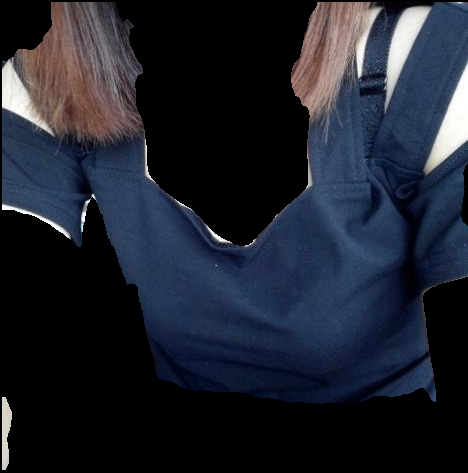

Crop: 005106_obj1_short_sleeve_top.png
Class: short_sleeve_top
Mean hue: 138.0, sat: 80.5, value: 98.9
Tone: cool | Brightness: medium
Suggestion: Warm-toned accessories (tan/brown) can soften the cool base.


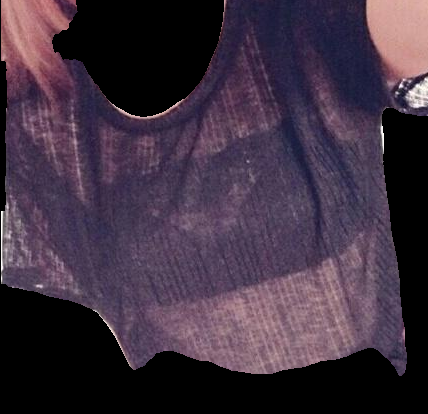

Crop: 006204_obj1_sling_dress.png
Class: sling_dress
Mean hue: 117.3, sat: 192.8, value: 70.9
Tone: cool | Brightness: dark
Suggestion: Add a pop of warm accent (rust/orange) for contrast.


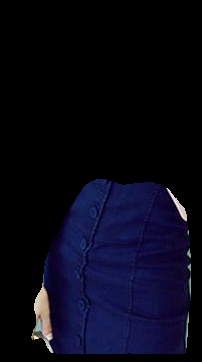

Crop: 003869_obj2_vest.png
Class: vest
Mean hue: 88.5, sat: 132.3, value: 101.5
Tone: cool | Brightness: medium
Suggestion: Warm-toned accessories (tan/brown) can soften the cool base.


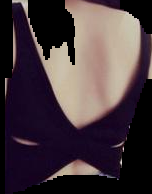

Crop: 000851_obj0_short_sleeve_top.png
Class: short_sleeve_top
Mean hue: 28.3, sat: 41.3, value: 209.2
Tone: neutral | Brightness: bright
Suggestion: Neutrals can pair with either warm or cool accent pieces depending on the vibe you want.


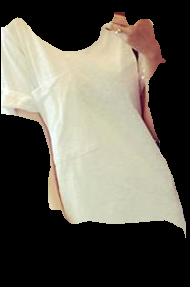

In [59]:
# load the features we just saved
df = pd.read_csv(FEAT_CSV)
print("Total crops with features:", len(df))

# look at a few random ones
sample = df.sample(min(5, len(df)), random_state=0)

from IPython.display import display
from PIL import Image

for _, row in sample.iterrows():
    crop_path = os.path.join(CROPS_DIR, row["crop_file"])
    tone = hue_to_tone(row["mean_h"])
    bright = value_to_brightness(row["mean_v"])
    suggestion = simple_color_suggestion(tone, bright)

    print("="*60)
    print("Crop:", row["crop_file"])
    print("Class:", row["class_name"])
    print(f"Mean hue: {row['mean_h']:.1f}, sat: {row['mean_s']:.1f}, value: {row['mean_v']:.1f}")
    print("Tone:", tone, "| Brightness:", bright)
    print("Suggestion:", suggestion)
    display(Image.open(crop_path))


Right now, with COCO YOLO:

We can do outfit-level color (from person)

Accessory-level color (from handbag, etc.)

But not robust per-garment classes like “shirt” vs “jeans”.